In [7]:
from modality.datasets import load_biomodal_dataset
from modality.contig_dataset import reduce_byranges
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
ds = load_biomodal_dataset("esE14")
ds =  ds.select_samples(["CEG1485-EL01-D1115-001"])
ds = ds.assign_fractions(numerators=["num_mc", "num_hmc","num_modc"], denominator="num_total_c", min_coverage=0)

In [9]:
bins = np.arange(-3050, 3050, 50)
from modality.annotation import get_tss_dist
x = get_tss_dist(reference = "mm10", ref_pos=ds['ref_position'], strand='+', return_nearest=False)
y = get_tss_dist(reference = "mm10", ref_pos=ds['ref_position'], strand='-', return_nearest=False)
tss_distance = np.where(np.abs(x) < np.abs(y), x, y)

2024-09-30 17:43:11 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)
2024-09-30 17:45:12 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


In [10]:
res = ds.reduce_bybins(tss_distance, bins=bins, var=['frac_hmc', 'frac_mc','frac_modc', 'num_total_c'])

In [11]:
df = res[['bin_midpoint', 'sample_id', 'frac_hmc_mean', 'frac_mc_mean', 'frac_modc_mean']].to_dataframe().reset_index()

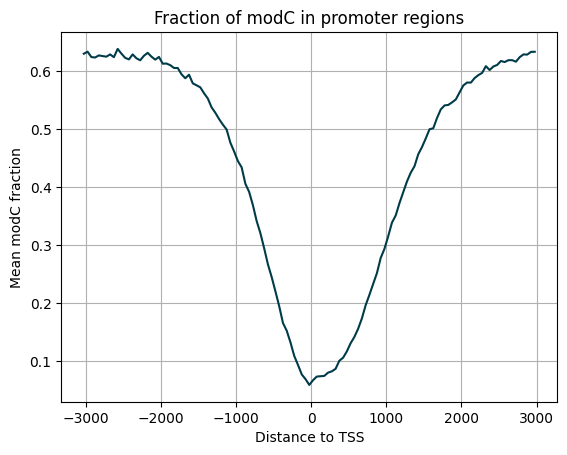

In [12]:
sns.lineplot(data=df, x='bin_midpoint', y='frac_modc_mean', hue='sample_id', legend=0)

plt.title("Fraction of modC in promoter regions")
#Rename the x-axis
plt.xlabel("Distance to TSS")
#Rename the y-axis
plt.ylabel("Mean modC fraction")
plt.grid(True)
plt.show()

In [13]:
import pandas as pd
from modality.annotation import get_transcripts

df_features = pd.read_pickle("rerun_CEGXRun1485.pickle")
transcripts = get_transcripts(
            reference="mm10",
            contig=None,
            start=None,
            end=None,
            as_pyranges=False,
        )
df_expression = pd.read_csv("../data/quant.sf", sep="\t")

def aggregate_expression(df_expression, transcripts, df_features):
    # Merging and calculating the summed TPM values in one line
    df_features["TPM"] = df_features["Gene_id"].map(
        df_expression
        .merge(transcripts[['id', 'parent', 'strand']], left_on='Name', right_on='id', how='left')
        .groupby('parent')['TPM']
        .sum()
    )

    # Filtering out rows with NaN values in the 'TPM' column
    return df_features[~df_features['TPM'].isna()]

def select_transcript_based_on_tag(df):
    # for each transcript in df, select the one with the highest priority tag
    # priorities are:
        # 1. 'basic,appris_principal_1,CCDS'
        # 2. 'basic,appris_principal_1'
        # 3. 'basic,CCDS'
        # 4. 'basic'
    # but with 'exp_conf' (experimentally confirmed) tag, the priority is higher.
    
    priorties = {
        'basic,appris_principal_1,exp_conf,CCDS': 1,
        'basic,appris_principal_1,CCDS': 1,
        'basic,appris_principal_1,exp_conf': 3,
        'basic,appris_principal_1': 4,
        'basic,exp_conf,CCDS': 5,
        'basic,CCDS': 6,
        'basic,exp_conf': 7,
        'basic': 8
    }

    # sort the dataframe by the priority of the tags
    df['tag_priority'] = df.tag.map(priorties)

    df = df.sort_values(by='tag_priority')

    # drop duplicates, keeping the first one
    df = df.drop_duplicates(subset='gene_id', keep='first')

    return df[["gene_id", "transcript_id"]]

def select_transcript(df_expression):
    selected_transcripts = transcripts.groupby('gene_id').apply(
        select_transcript_based_on_tag
        ).reset_index(drop=True)
    full_selected_transcript = pd.merge(selected_transcripts,transcripts, left_on='transcript_id', right_on='id', how='right')

    # Merge df_expression with transcripts on the matching columns
    merged_df = pd.merge(full_selected_transcript[['id', 'parent', 'strand']], df_expression, left_on='id', right_on='Name', how='left')
    merged_df = pd.merge(merged_df, df_features[['Gene_id','contig']], left_on='parent', right_on='Gene_id', how='left')
    df_expression['Gene_id'] = merged_df['parent']
    df_expression['strand'] = merged_df['strand']
    df_expression['contig'] = merged_df['contig']
    df_expression = df_expression[~df_expression.isna().any(axis=1)]

    return df_expression
    

2024-09-30 17:47:25 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


In [19]:
df_expression_updated= select_transcript(df_expression)


In [27]:
df_expression_updated["TPM_T"].max()

16.899306166767893

subplots under "Summarise Gene Expression Across All Isoforms" sections 

/tmp/ipykernel_1777079/2990544476.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expression_updated['Dataset'] = 'Principal Isoform'
/tmp/ipykernel_1777079/2990544476.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expression_updated["TPM_T"] = np.log2(df_expression_updated["TPM"]+constant_updated)


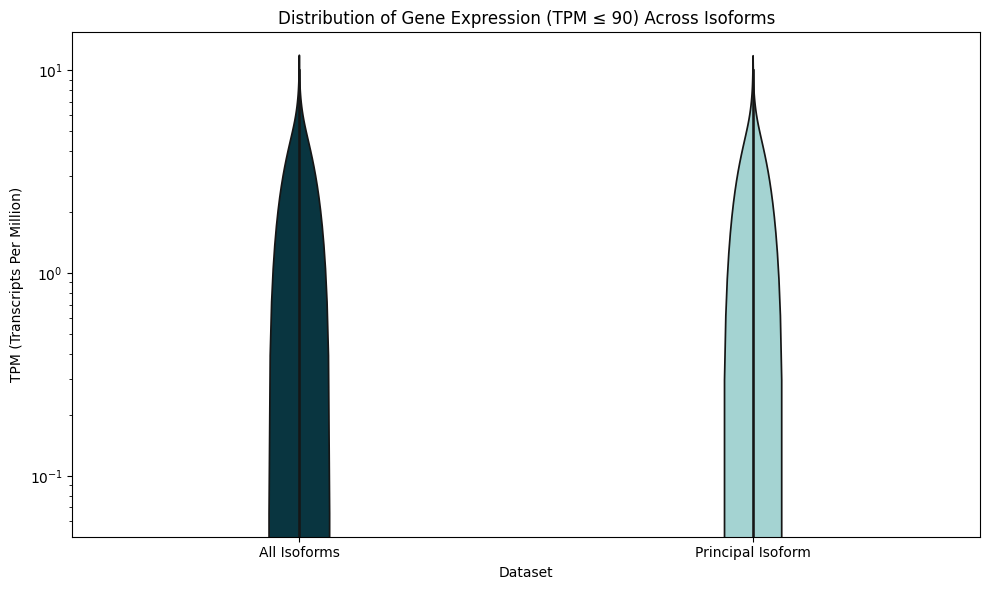

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the custom color palette
biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]

# Assuming df_expression and df_expression_updated are already loaded as DataFrames

# Add a column to distinguish between datasets
df_expression['Dataset'] = 'All Isoforms'
df_expression_updated['Dataset'] = 'Principal Isoform'

constant = df_expression[df_expression["TPM"]>0]["TPM"].min()/1000
constant_updated = df_expression_updated[df_expression_updated["TPM"]>0]["TPM"].min()/1000

df_expression["TPM_T"] = np.log2(df_expression_updated["TPM"]+constant)
df_expression_updated["TPM_T"] = np.log2(df_expression_updated["TPM"]+constant_updated)

# Concatenate both datasets for comparison
df_combined = pd.concat([df_expression[['TPM_T', 'Dataset']], 
                         df_expression_updated[['TPM_T', 'Dataset']]])

# Filter out extreme values where TPM > 90
df_combined_filtered = df_combined[df_combined['TPM_T'] <= 10]

# Create the violin plot using the custom biomodal palette
plt.figure(figsize=(10, 6))
sns.violinplot(x='Dataset', y='TPM_T', data=df_combined_filtered, 
               scale='width', palette=biomodal_palette[:2])  # Use only two colors from the palette

# Customize the plot
plt.title('Distribution of Gene Expression (TPM ≤ 90) Across Isoforms')
plt.ylabel('TPM (Transcripts Per Million)')
plt.xlabel('Dataset')
plt.yscale('log')  # Using log scale to better visualize the distribution
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_1777079/1823535587.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expression_updated['Dataset'] = 'Principal Isoform'
/tmp/ipykernel_1777079/1823535587.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expression_updated["TPM_T"] = np.log2(df_expression_updated["TPM"] + constant_updated)


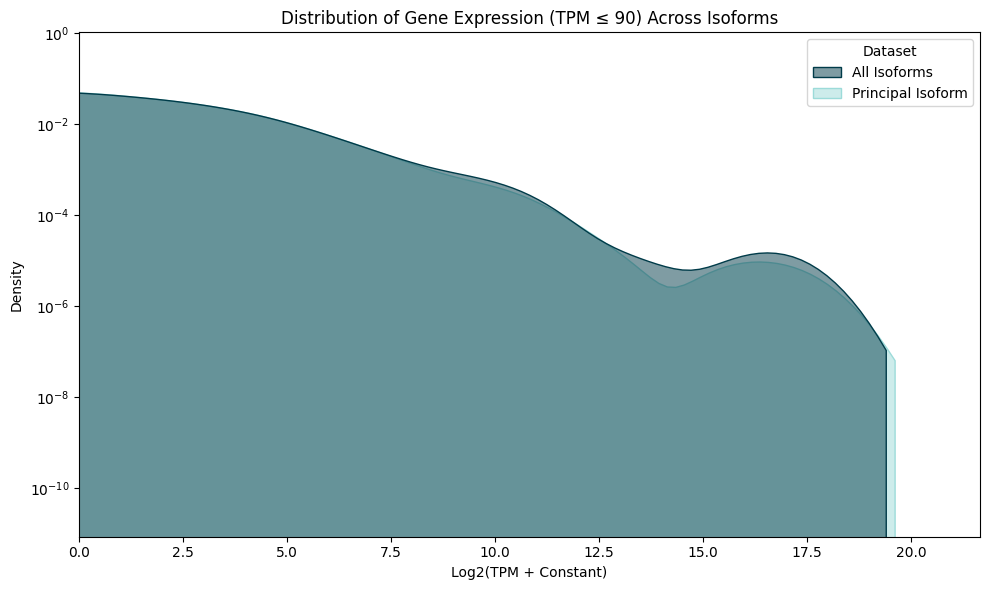

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the custom color palette
biomodal_palette = ["#003B49", "#9CDBD9"]

# Assuming df_expression and df_expression_updated are already loaded as DataFrames

# Add a column to distinguish between datasets
df_expression['Dataset'] = 'All Isoforms'
df_expression_updated['Dataset'] = 'Principal Isoform'

# Calculate constants for log transformation
constant = df_expression[df_expression["TPM"] > 0]["TPM"].min() / 1000
constant_updated = df_expression_updated[df_expression_updated["TPM"] > 0]["TPM"].min() / 1000

# Apply log transformation
df_expression["TPM_T"] = np.log2(df_expression["TPM"] + constant)
df_expression_updated["TPM_T"] = np.log2(df_expression_updated["TPM"] + constant_updated)

# Concatenate both datasets for comparison
df_combined = pd.concat([df_expression[['TPM_T', 'Dataset']], 
                         df_expression_updated[['TPM_T', 'Dataset']]])

# Filter out extreme values where TPM > 10 (as TPM_T <= 10 after log transformation)
df_combined_filtered = df_combined[df_combined['TPM_T'] <=20]

# Create the plot using kernel density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_combined_filtered, x='TPM_T', hue='Dataset', 
             palette=biomodal_palette, fill=True, common_norm=False, alpha=0.5)

# Customize the plot
plt.title('Distribution of Gene Expression (TPM ≤ 90) Across Isoforms')
plt.ylabel('Density')
plt.xlabel('Log2(TPM + Constant)')
plt.yscale('log')  # Using log scale for better visualization, if desired
plt.xlim(left=0)  # Optionally set x-axis limits
plt.tight_layout()

# Show the plot
plt.show()


In [13]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming df_expression and df_expression_updated are loaded DataFrames

# # Pivot the data to have genes as rows and isoforms as columns, filling missing values with 0
# # Ensure that for each gene_id, you have the isoforms' TPM data

# # Group by Gene_id and aggregate by the mean TPM for isoforms (if applicable)
# df_isoform_expression = df_expression.pivot_table(values='TPM', index='Gene_id', columns='Name', fill_value=0)

# # Compute the correlation matrix
# correlation_matrix = df_isoform_expression.corr()

# # Set up the matplotlib figure
# plt.figure(figsize=(12, 10))

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f", 
#             square=True, linewidths=.5, cbar_kws={"shrink": .8})

# # Customize the plot
# plt.title('Isoform Expression Correlation Heatmap')
# plt.tight_layout()

# # Show the plot
# plt.show()


: 

: 

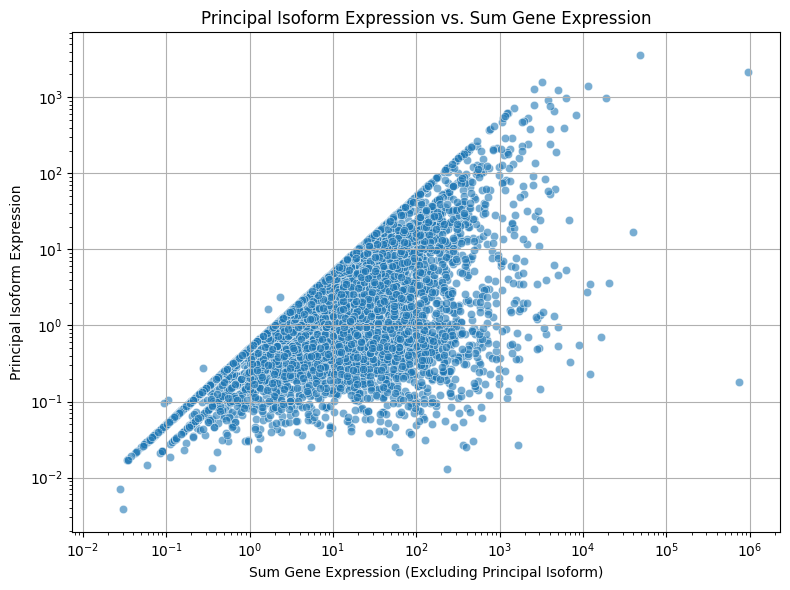

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_expression (original data with all isoforms) and df_expression_updated (principal isoform) are loaded

# Step 1: Compute the gene-level average expression (excluding the principal isoform)
# Merge both dataframes on 'Gene_id'
df_merged = pd.merge(df_expression, df_expression_updated[['Gene_id', 'Name', 'TPM']], 
                     on='Gene_id', suffixes=('_all_isoforms', '_principal'))

# Compute the average expression for all isoforms except the principal isoform
df_merged['sum_expression'] = df_merged.groupby('Gene_id')['TPM_all_isoforms'].transform(lambda x: x.sum())

# Step 2: Filter for principal isoforms only and avoid duplicates in the merge
df_principal_vs_gene = df_merged.drop_duplicates(subset='Gene_id')[['TPM_principal', 'sum_expression']]

# Step 3: Plot a scatter plot showing principal isoform vs averaged gene expression
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sum_expression', y='TPM_principal', data=df_principal_vs_gene, alpha=0.6)

# Customize the plot
plt.title('Principal Isoform Expression vs. Sum Gene Expression')
plt.xlabel('Sum Gene Expression (Excluding Principal Isoform)')
plt.ylabel('Principal Isoform Expression')
plt.yscale('log')  # Optionally use log scale to handle spread
plt.xscale('log')  # Optional for same reason
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()



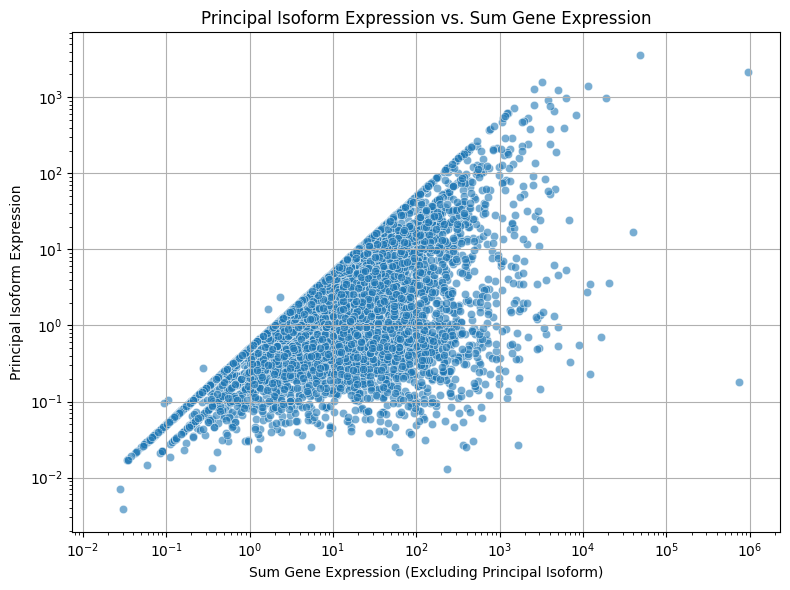

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]

# If there is a 'Category' column in your data, you can map it to color using the palette
# (assuming 'Category' column exists and denotes clusters/groups)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sum_expression', y='TPM_principal', data=df_principal_vs_gene, 
                alpha=0.6)

# Customize the plot
plt.title('Principal Isoform Expression vs. Sum Gene Expression')
plt.xlabel('Sum Gene Expression (Excluding Principal Isoform)')
plt.ylabel('Principal Isoform Expression')
plt.yscale('log')  # Use log scale for better spread visualization
plt.xscale('log')  # Log scale for x-axis as well
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
